In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

from sentence_transformers import SentenceTransformer
from matplotlib.colors import ListedColormap

from matplotlib import cm
from lonboard._map import Map
from lonboard._layer import PolygonLayer
from lonboard.colormap import (
    apply_continuous_cmap,
)
from matplotlib.colors import LogNorm
from palettable.colorbrewer.sequential import PuRd_9

In [ ]:
mn_blocks_gdf = gpd.read_file("manhattan_block_features.geojson")
print(mn_blocks_gdf.columns)

Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'bctcb2020', 'geoid',
       'shape_leng', 'shape_area', 'BldgArea', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotArea', 'YearBuilt', 'ComArea', 'NumBldgs',
       'embedding', 'cluster', 'places_embedding',
       'places_multimodal_embedding', 'places_multimodal_cluster', 'geometry'],
      dtype='object')


In [3]:
pluto_gdf = gpd.read_file("nyc_mappluto/MapPLUTO.shp")

In [4]:
# Rename BCTCB2020 to lowercase for merging
# Standardize column names and filter for Manhattan
pluto_gdf = pluto_gdf.rename(columns={"BCTCB2020": "bctcb2020"})
manhattan_pluto_gdf = pluto_gdf[pluto_gdf["Borough"] == "MN"].copy()

# Reproject only if not already in EPSG:4326
if manhattan_pluto_gdf.crs != "EPSG:4326":
    manhattan_pluto_gdf = manhattan_pluto_gdf.to_crs("EPSG:4326")

In [ ]:
# Run k-means clustering for spatial embeddings
n_clusters = 8

if mn_blocks_gdf["embedding"].count() != mn_blocks_gdf["cluster"].count():
    print(f"Running k means on spatial embeddings with {n_clusters} clusters.")

    feature_cols = [
        "BldgArea",
        "NumFloors",
        "UnitsRes",
        "UnitsTotal",
        "LotArea",
        "YearBuilt",
        "ComArea",
        "NumBldgs",
    ]

    # Create embedding (as a numpy array)
    mn_blocks_gdf["spatial_embedding"] = mn_blocks_gdf[feature_cols].apply(
        lambda row: row.values.astype(float), axis=1
    )

    X = np.vstack(mn_blocks_gdf["spatial_embedding"].values)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    mn_blocks_gdf["spatial_cluster"] = kmeans.fit_predict(X)

Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'bctcb2020', 'geoid',
       'shape_leng', 'shape_area', 'BldgArea', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotArea', 'YearBuilt', 'ComArea', 'NumBldgs',
       'embedding', 'cluster', 'places_embedding',
       'places_multimodal_embedding', 'places_multimodal_cluster', 'geometry'],
      dtype='object')
Running k means on spatial embeddings with 8 clusters.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'bctcb2020', 'geoid',
       'shape_leng', 'shape_area', 'BldgArea', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotArea', 'YearBuilt', 'ComArea', 'NumBldgs',
       'embedding', 'cluster', 'places_embedding',
       'places_multimodal_embedding', 'places_multimodal_cluster', 'geometry',
       'spatial_embedding', 'spatial_cluster'],
      dtype='object')


In [29]:
# run k means clustering for semantic embeddings

if (
    mn_blocks_gdf["places_multimodal_embedding"].count()
    != mn_blocks_gdf["places_multimodal_cluster"].count()
):
    print(f"Running k means on semantic embeddings with {n_clusters} clusters.")
    # Get all non-empty multimodal embedding strings from the whole file
    multimodal_strings = [
        emb
        for emb in mn_blocks_gdf["places_multimodal_embedding"]
        if isinstance(emb, str) and emb.strip() != ""
    ]

    # Generate sentence transformer embeddings
    model = SentenceTransformer("all-MiniLM-L6-v2")
    multimodal_vectors = model.encode(multimodal_strings)

    # Run k-means clustering
    kmeans_multi = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans_multi.fit_predict(multimodal_vectors)

    # Assign clusters back to the DataFrame (only for rows with valid embeddings)
    mn_blocks_gdf.loc[
        mn_blocks_gdf["places_multimodal_embedding"].apply(
            lambda x: isinstance(x, str) and x.strip() != ""
        ),
        "places_multimodal_cluster",
    ] = clusters

Running k means on semantic embeddings with 8 clusters.


/Users/elliemadsen/miniforge3/envs/cdp/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


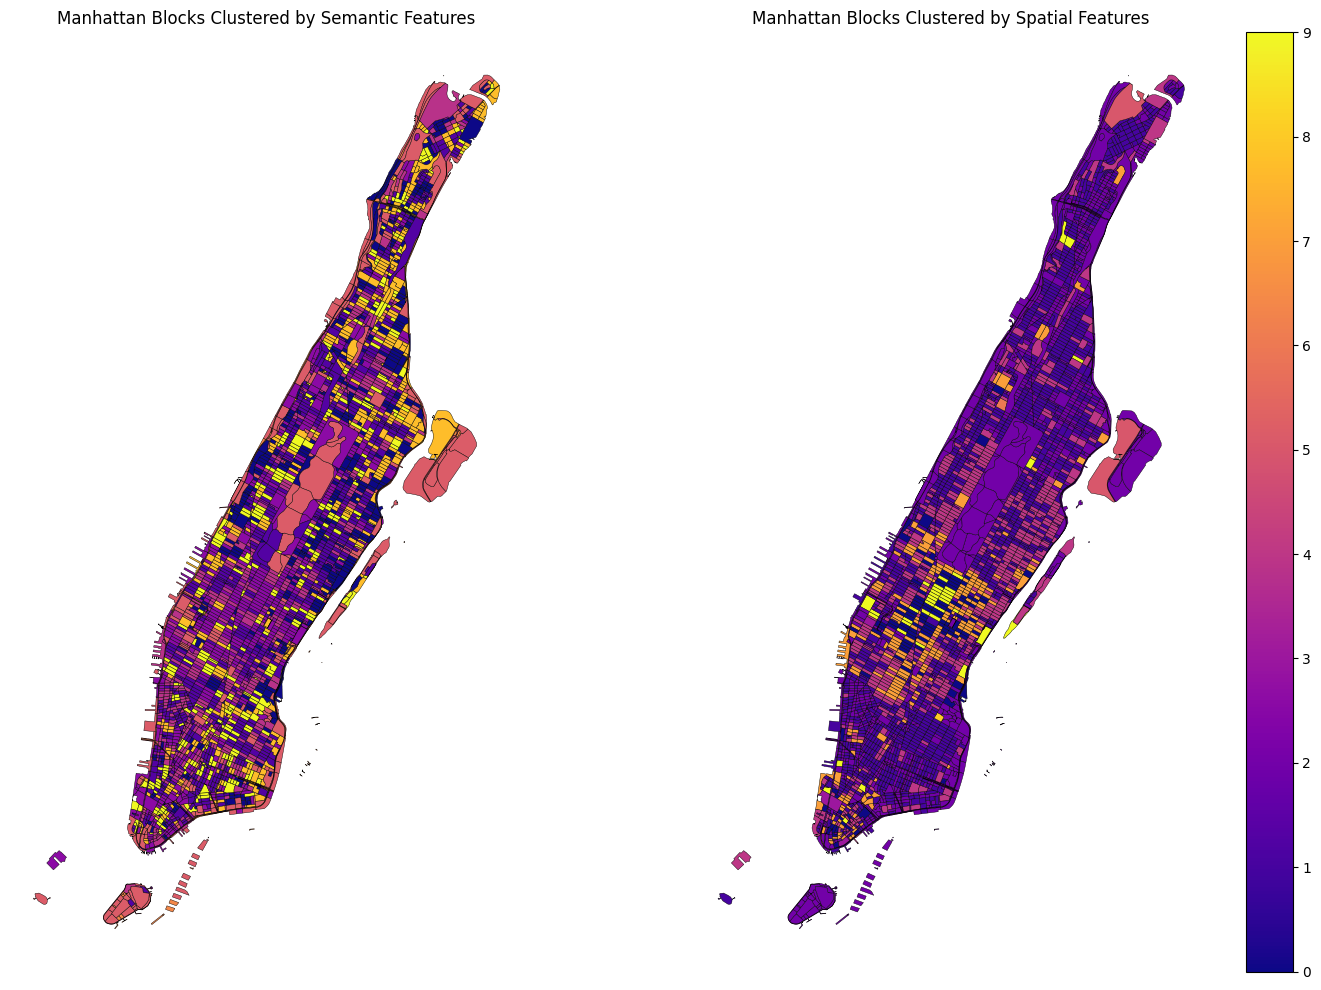

In [34]:
# map cluster and places_multimodal_cluster

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Semantic clusters (no legend)
mn_blocks_gdf.plot(
    ax=axes[0],
    column="places_multimodal_cluster",
    cmap=cm.plasma_r,
    edgecolor="black",
    linewidth=0.3,
    legend=False,
)
axes[0].set_title("Manhattan Blocks Clustered by Semantic Features")
axes[0].set_aspect("equal")
axes[0].axis("off")

# Spatial clusters
mn_blocks_gdf.plot(
    ax=axes[1],
    column="cluster",
    cmap=cm.plasma,
    edgecolor="black",
    linewidth=0.3,
    legend=True,
)
axes[1].set_title("Manhattan Blocks Clustered by Spatial Features")
axes[1].set_aspect("equal")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [44]:
# Select relevant columns from pluto
manhattan_pluto_gdf_simple = manhattan_pluto_gdf[["NumFloors", "geometry", "bctcb2020"]]

# Merge pluto with mn_blocks_gdf to get clusters per bldg
mn_bldg_blocks_gdf = manhattan_pluto_gdf_simple.merge(
    mn_blocks_gdf[["bctcb2020", "spatial_cluster", "places_multimodal_cluster"]],
    on="bctcb2020",
    how="left",
)

In [47]:
normalizer = LogNorm(1, mn_bldg_blocks_gdf.spatial_cluster.max(), clip=True)
normalized_clusters = normalizer(mn_bldg_blocks_gdf.spatial_cluster)

layer = PolygonLayer.from_geopandas(
    mn_bldg_blocks_gdf[["spatial_cluster", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_clusters, cmap=cm.plasma),
    extruded=True,
    get_elevation=manhattan_pluto_gdf["NumFloors"] * 14,
)
m = Map(
    layer, view_state={"longitude": -73.97, "latitude": 40.73, "zoom": 11, "pitch": 45}
)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x337ae7340>
[
  49,
 …

In [ ]:
normalizer = LogNorm(1, mn_bldg_blocks_gdf.places_multimodal_cluster.max(), clip=True)
normalized_clusters = normalizer(mn_bldg_blocks_gdf.places_multimodal_cluster)

layer = PolygonLayer.from_geopandas(
    mn_bldg_blocks_gdf[["places_multimodal_cluster", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_clusters, cmap=cm.plasma_r),
    extruded=True,
    get_elevation=manhattan_pluto_gdf["NumFloors"] * 14,
)
m = Map(
    layer, view_state={"longitude": -73.97, "latitude": 40.73, "zoom": 11, "pitch": 45}
)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x337ae5360>
[
  49,
 …

In [50]:
normalizer = LogNorm(1, mn_blocks_gdf.places_multimodal_cluster.max(), clip=True)
normalized_clusters = normalizer(mn_blocks_gdf.places_multimodal_cluster)

layer = PolygonLayer.from_geopandas(
    mn_blocks_gdf[["places_multimodal_cluster", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_clusters, cmap=cm.plasma_r),
    extruded=True,
    get_elevation=mn_blocks_gdf["NumFloors"].fillna(1)
    * 14,  # Use block NumFloors or fillna
)
m = Map(
    layer, view_state={"longitude": -73.97, "latitude": 40.73, "zoom": 11, "pitch": 45}
)
m

/Users/elliemadsen/miniforge3/envs/cdp/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x342494ac0>
[
  0,
  …